In [280]:
%pylab inline
import numpy as np
import pandas as pd

import sys; sys.path.append("../")
import metrics

import pickle
import seaborn as sns
sns.set_style('whitegrid')
from tqdm import tqdm_notebook as tqdm

from importlib import reload
import util
reload(util)

Populating the interactive namespace from numpy and matplotlib


/data/jonas/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<module 'util' from '../util.py'>

In [256]:
# mean spectrum
spect_df = []
for nuc in ['1H', '13C']:
    
    spect_filename = f'../dataset.named/spectra.nmrshiftdb_{nuc}.feather'
    a = pd.read_feather(spect_filename)
    a['nuc'] = nuc
    spect_df.append(a)
spect_df = pd.concat(spect_df)
spect_agg_df = spect_df.groupby(['molecule_id', 'atom_idx']).agg({'value' : 'median'})
spect_agg_df.head()

value
molecule_id atom_idx       
4001        0          18.3
            1          41.8
            2          33.5
            3          42.2
            4          42.0

# clean hose data

In [257]:
# clean up and sort hose data
hose_preds_df = pd.read_feather("../hose/hose_preds_df.feather")
### FIXME

del hose_preds_df['id']
del hose_preds_df['value']
del hose_preds_df['delta']
del hose_preds_df['delta_abs'] # .groupby(["mol_id", 'atom_idx'])
hose_preds_df = hose_preds_df.join(spect_agg_df, on =['mol_id', 'atom_idx'])

print("WARNING WHY DO WE HAVE NANS IN HOSE_PREDS")
print(len(hose_preds_df))
print(len(hose_preds_df.dropna()))
hose_preds_df = hose_preds_df.dropna()

hose_preds_df['delta'] = hose_preds_df.value - hose_preds_df.pred
hose_preds_df['delta_abs'] = np.abs(hose_preds_df.delta)
hose_preds_df['delta_sq'] = np.abs(hose_preds_df.delta**2)

a = []


for nuc, df_nuc in hose_preds_df.groupby('nuc', as_index=False):
    df_nuc = df_nuc.copy()
    for sphere_min in [1, 2, 3, 4, 5, 6]:
        b = df_nuc[df_nuc.sphere_no >= sphere_min].copy()
        b['sphere_min'] = sphere_min
        a.append(b)
a = pd.concat(a)
hose_sphere_scores_df  = a.groupby(['nuc', 'sphere_min']).apply(metrics.compute_stats, 
                                                                mol_id_field='mol_id').reset_index()


WARNING WHY DO WE HAVE NANS IN HOSE_PREDS
341139
339835


In [233]:
print(len(hose_preds_df))
print(len(hose_preds_df.dropna()))

423115
423115


In [259]:
hose_sphere_scores_df['total_atom_n'] = 0
hose_sphere_scores_df.loc[hose_sphere_scores_df.nuc == '13C', 
                          'total_atom_n'] = len(hose_preds_df[hose_preds_df.nuc == '13C'])

hose_sphere_scores_df.loc[hose_sphere_scores_df.nuc == '1H', 
                          'total_atom_n'] = len(hose_preds_df[hose_preds_df.nuc == '1H'])

hose_sphere_scores_df['nuc_frac'] = hose_sphere_scores_df.n / hose_sphere_scores_df.total_atom_n

# neural net data

In [355]:
from glob import glob
all_df = []
for filename in glob("../preds/1H_good_cv?.feather.200"):
    df = pd.read_feather(filename)
    df['filename'] = filename
    all_df.append(df)

for filename in glob("../preds/13C_good_cv?.feather.300"):
    df = pd.read_feather(filename)
    df['filename'] = filename
    all_df.append(df)
        
    
nn_results_df = pd.concat(all_df)
nn_results_df = nn_results_df[nn_results_df.phase == 'test'].copy()

nn_results_df = nn_results_df.drop_duplicates(subset=['molecule_id', 'atom_idx'])
del nn_results_df['value']
nn_results_df = nn_results_df.join(spect_agg_df, on =['molecule_id', 'atom_idx'])


nn_results_df['delta'] = nn_results_df.value - nn_results_df.pred_mu
nn_results_df['delta_abs'] = np.abs(nn_results_df.delta)
nn_results_df['delta_sq'] = np.abs(nn_results_df.delta**2)


In [260]:
nn_results_df = []
for nuc, filename, tgt_epoch in [('13C', "../preds/13C_good_all.meta.pickle", 300), 
                                ('1H', "../preds/1H_good_all.meta.pickle", 200)
                                ]:

    meta_info = pickle.load(open(filename, 'rb'))
    meta_df = meta_info['meta']
    epoch_filename = meta_df[meta_df.epoch == tgt_epoch].iloc[0].epoch_filename

    results_df = pd.read_feather("../" + epoch_filename)
    results_df['nuc'] = nuc

    nn_results_df.append(results_df)
nn_results_df = pd.concat(nn_results_df)

nn_results_df = nn_results_df.drop_duplicates(subset=['molecule_id', 'atom_idx'])
del nn_results_df['value']
nn_results_df = nn_results_df.join(spect_agg_df, on =['molecule_id', 'atom_idx'])


nn_results_df['delta'] = nn_results_df.value - nn_results_df.pred_mu
nn_results_df['delta_abs'] = np.abs(nn_results_df.delta)
nn_results_df['delta_sq'] = np.abs(nn_results_df.delta**2)

In [356]:
nn_fracs = []
for nuc in ['13C', '1H']:
    a = nn_results_df[nn_results_df.nuc == nuc]
    a = a[a.phase == 'test']
    a = a.sort_values('pred_std')
    m = np.array(a.delta_abs.expanding().mean())
    frac_data = np.arange(len(m))/len(m)
    nn_fracs.append(pd.DataFrame({'mean_abs' : m, 'frac' : frac_data, 'nuc' : nuc}))
nn_fracs_df = pd.concat(nn_fracs)

# plot both

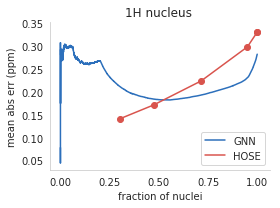

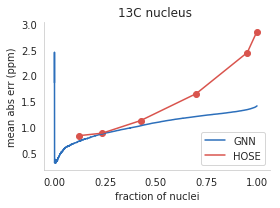

In [357]:


for nuc in ['1H', '13C']:

    fig = pylab.figure(figsize=(4, 3))
    ax = fig.add_subplot(1, 1, 1)
    a = nn_fracs_df[nn_fracs_df.nuc == nuc]
    ax.plot(a.frac, a.mean_abs, label='GNN', c=sns.xkcd_rgb["medium blue"])


    b = hose_sphere_scores_df[hose_sphere_scores_df.nuc == nuc]
    ax.plot(b.nuc_frac, b.mean_abs, c=sns.xkcd_rgb["pale red"], label='HOSE')
    ax.scatter(b.nuc_frac, b.mean_abs, c=sns.xkcd_rgb["pale red"], label=None)
    ax.set_title(f'{nuc} nucleus ')
    ax.set_ylabel("mean abs err (ppm)")
    ax.set_xlabel("fraction of nuclei")
    ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
    sns.despine()
    ax.grid(False)
    pylab.legend()
    fig.tight_layout()
    fig.savefig(f"compare results.nn_vs_hose_frac.{nuc}.pdf")

# Load Ab initio

In [358]:
nmrab_results_raw_df = pd.read_feather("../../nmrabinitio/simulate.gaussian/nmr/pop_32_300_HCON_macro_tantillo1_geom_nmr.shifts.feather")
print("total ab molecules:", len(nmrab_results_raw_df.mol_id.unique()))
# do a little cleanup:


nmrab_results_df = nmrab_results_raw_df[['mol_id', 'atom_idx',  'pred', 'element']].drop_duplicates(subset=['mol_id', 'atom_idx']).copy()

nmrab_results_df = nmrab_results_df.join(spect_agg_df, on =['mol_id', 'atom_idx'])


nmrab_results_df['nuc'] = nmrab_results_df.element.apply(lambda x: '13C' if x =='C' else  '1H')


nmrab_results_df['delta'] = nmrab_results_df.value - nmrab_results_df.pred
nmrab_results_df['delta_abs'] = np.abs(nmrab_results_df.delta)
nmrab_results_df['delta_sq'] = np.abs(nmrab_results_df.delta**2)



total ab molecules: 194


# Combine data

In [359]:
# Combine
a = nmrab_results_df.copy()
del a['element']
a['method'] = 'abinitio'

b = hose_preds_df.copy()
del b['sphere_no']
#del b['id']
del b['filename']
b = b.dropna()
b['mol_id'] = b.mol_id.astype(int)
b['method'] ='hose'

c = nn_results_df[nn_results_df.phase == 'test'].copy()
c['pred'] = c['pred_mu']
c['mol_id'] = c['molecule_id']
for f in ['m_pos', 'nuc_i', 'pred_mu', 'pred_std', 'molecule_id', 'phase', 'epoch_i', 'delta_sq']:
    del c[f]
c['method'] = 'gnn'

all_pred_df = pd.concat([a, b, c], sort=False)
common_mols = set(a.mol_id).intersection(set(b.mol_id).intersection(set(c.mol_id)))
all_pred_common_df = all_pred_df[all_pred_df.mol_id.isin(common_mols)]

In [360]:
all_pred_common_df.groupby(['nuc', 'method']).apply(metrics.compute_stats, 
                                                                mol_id_field='mol_id')

mol_MAE   mol_MSE  mean_abs       std       n  mol_n
nuc method                                                         
13C abinitio  1.715791  2.103969  1.593193  2.325279  1346.0  191.0
    gnn       0.956912  1.155720  0.915575  1.464932  1041.0  149.0
    hose      2.361856  3.182079  2.018634  3.611188  1350.0  191.0
1H  abinitio  0.381666  0.583926  0.340026  0.895778  1355.0  181.0
    gnn       0.282651  0.394013  0.260523  0.631381  1355.0  181.0
    hose      0.391450  0.540497  0.356043  0.781667  1355.0  181.0

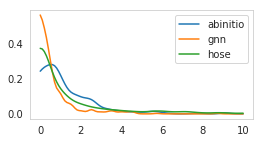

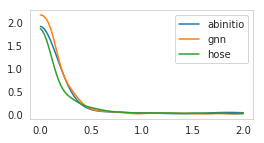

In [361]:
import scipy.stats
nuc_bins = {'13C' : np.linspace(0, 10, 100), 
       '1H' : np.linspace(0, 2, 100)}
nuc_bw = {'13C' : 0.1, '1H' : 0.1}

for nuc, nuc_g in all_pred_common_df.groupby('nuc'):
    fig = pylab.figure(figsize=(4, 2))
    ax =fig.add_subplot(1, 1, 1)
    bins = nuc_bins[nuc]
    for method, method_g in nuc_g.groupby('method'):
        k = scipy.stats.gaussian_kde(method_g.delta, bw_method=nuc_bw[nuc])
        pylab.plot(bins, k(bins), label=method)
        ax.grid(False)
    pylab.legend()

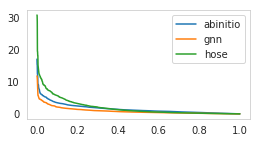

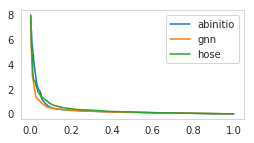

In [362]:
import scipy.stats
nuc_bins = {'13C' : np.linspace(0, 10, 20), 
       '1H' : np.linspace(0, 2, 100)}
nuc_bw = {'13C' : 0.1, '1H' : 0.1}

for nuc, nuc_g in all_pred_common_df.groupby('nuc'):
    fig = pylab.figure(figsize=(4, 2))
    ax =fig.add_subplot(1, 1, 1)
    bins = nuc_bins[nuc]
    for method, method_g in nuc_g.groupby('method'):
        y = np.sort(method_g.delta_abs)[::-1]
        x = np.arange(len(y))/len(y)
        #h, _= np.histogram(method_g.delta, bins=bins)
        pylab.plot(x, y, label=method)
        ax.grid(False)
    pylab.legend()

/data/jonas/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


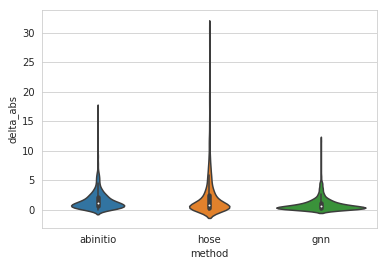

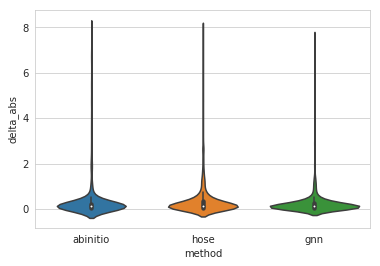

In [363]:
for nuc, nuc_g in all_pred_common_df.groupby('nuc'):
    pylab.figure()
    sns.violinplot(x='method', y='delta_abs', data=nuc_g)

# which atoms in molecule

In [364]:
mol_df = pickle.load(open("../dataset.named/molconf.nmrshiftdb_hconfspcl_nmrshiftdb.pickle", 'rb'))['df']
neighbors_df = util.mol_df_to_neighbor_atoms(mol_df)


100%|██████████| 34974/34974 [00:08<00:00, 4274.42it/s]


In [365]:
a = all_pred_common_df.join(neighbors_df, on=['mol_id', 'atom_idx'])
cat_df = []
for e in ['H', 'C', 'O', 'Cl', 'F', 'N', 'S', 'P']:
    b = a[a[e] > 0].copy()
    b['bond'] = e
    cat_df.append(b)
cat_df = pd.concat(cat_df)

/data/jonas/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

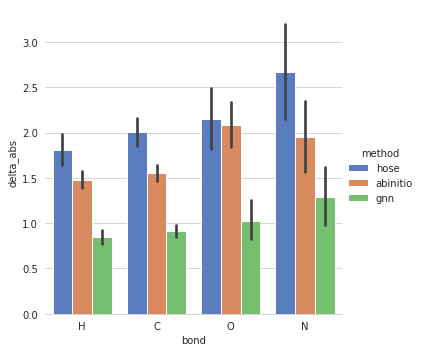

<Figure size 432x288 with 0 Axes>

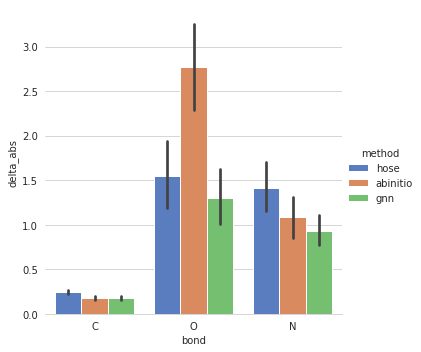

In [366]:
for nuc, nuc_df in cat_df.groupby('nuc'):
    pylab.figure()
    g = sns.catplot(x='bond', y='delta_abs', hue='method',
                data=nuc_df, kind="bar", palette="muted", #ci='sd',
                    hue_order=['hose', 'abinitio', 'gnn'])
    
    g.despine(left=True)


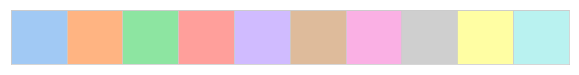

In [354]:
sns.palplot(sns.color_palette("pastel"))
